<a href="https://colab.research.google.com/github/EugeneGene/udacity_datascience_for_scientists_deeplearning/blob/t3_p4_cifar10/CIFAR_10_Image_Classifier_STARTER_REBEdit_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [6]:
from torchvision import datasets
import os
from torch.utils.data import DataLoader, random_split

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [15]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),              # Resize to 32x32
    transforms.RandomCrop(32, padding=4),     # Random cropping with padding
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),              # Resize to 32x32
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create training set and define training dataloader
train_data = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=True, transform=train_transforms)

# Split the training data into train and validation datasets
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create data loaders for train, validation, and test sets
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=False, transform=test_transforms)
testloader = DataLoader(test_data, batch_size=batch_size)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Training Data
dog


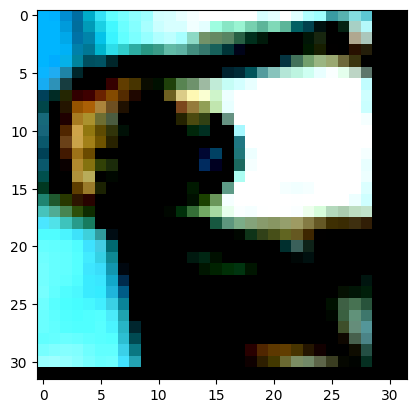

dog


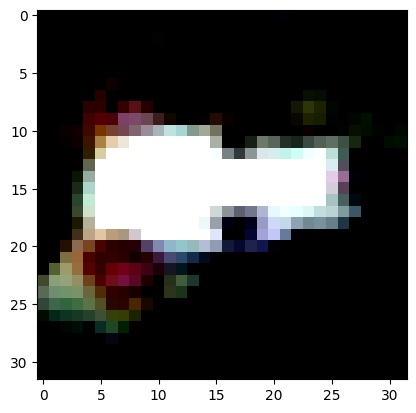

truck


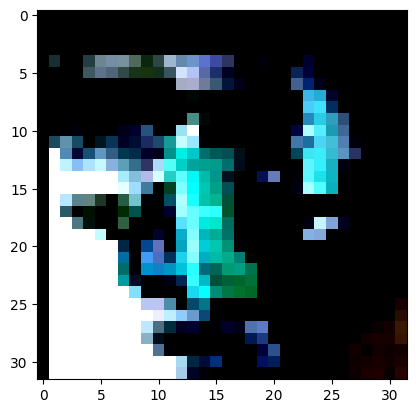

car


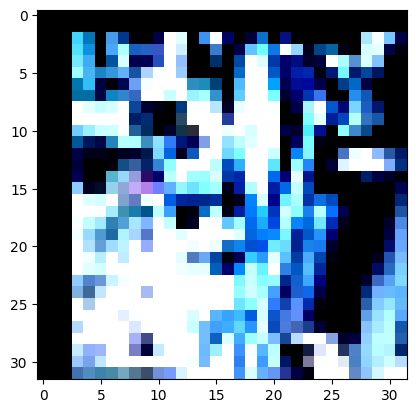

deer


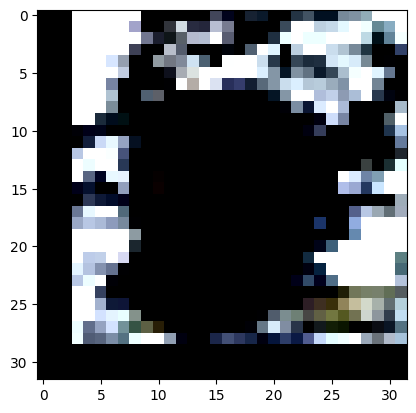

In [ ]:
# Explore data
# Training Set
print("Training Data")
show5(trainloader)

Alternative Implementation to view data

In [13]:
def show5_regedit(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.show()

Train Data
car


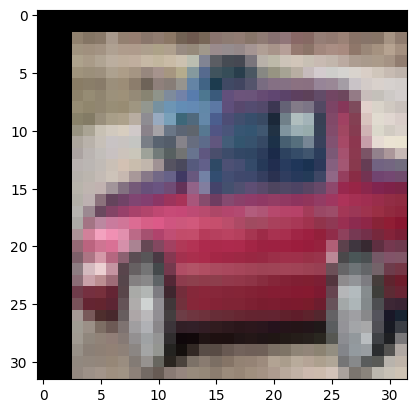

horse


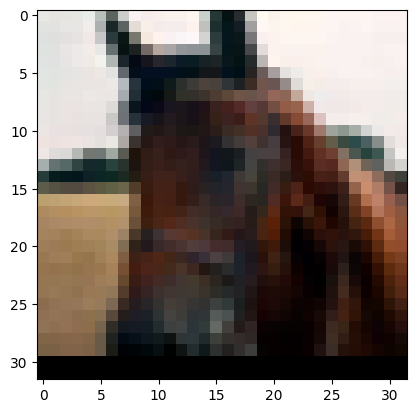

deer


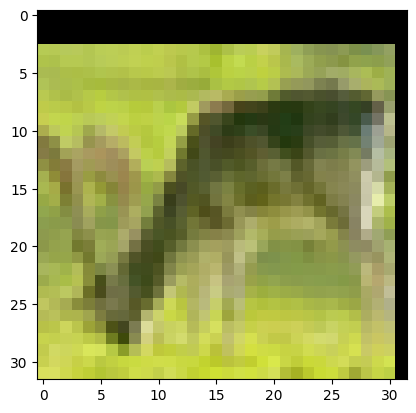

horse


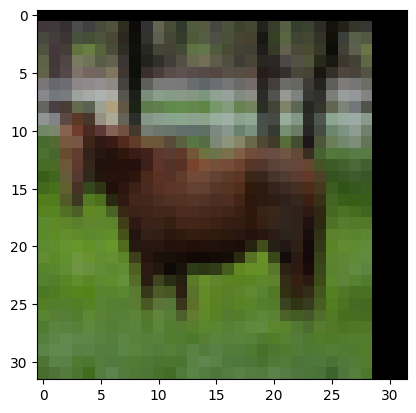

truck


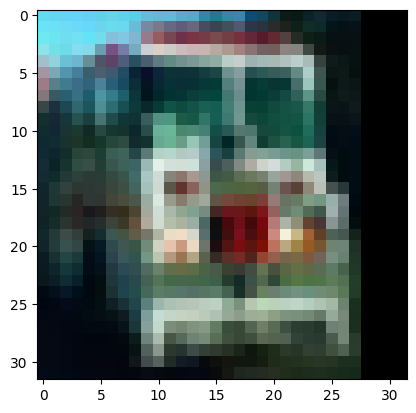

In [21]:
# Train Set
print("Train Data")
show5_regedit(trainloader)

Validation Data
bird


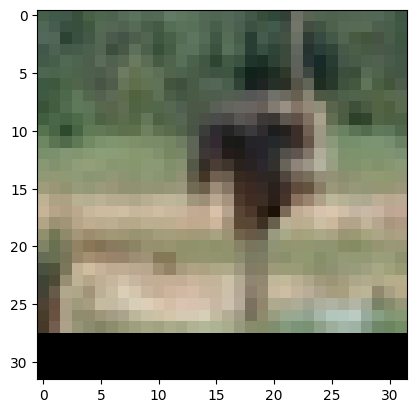

bird


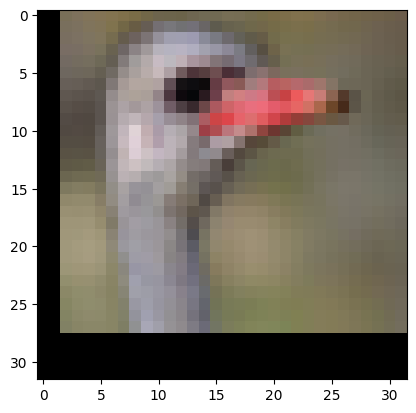

horse


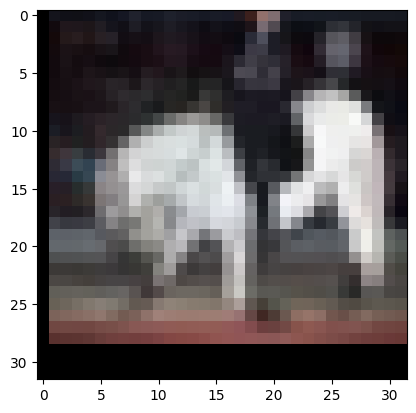

cat


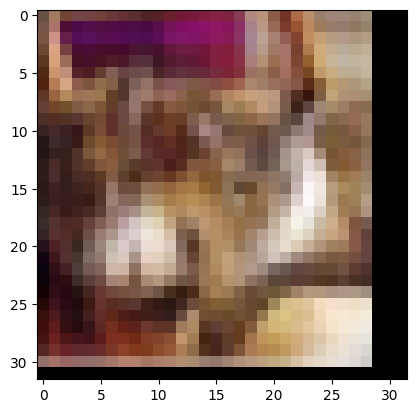

deer


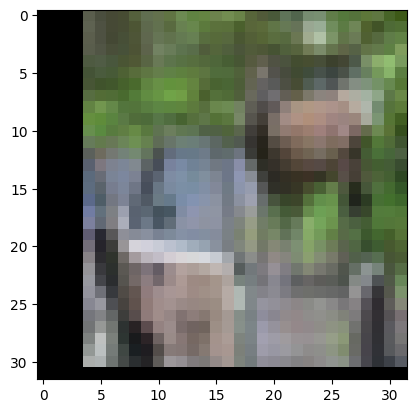

In [19]:
# Validation Set
print("Validation Data")
show5_regedit(valloader)

Test Data
cat


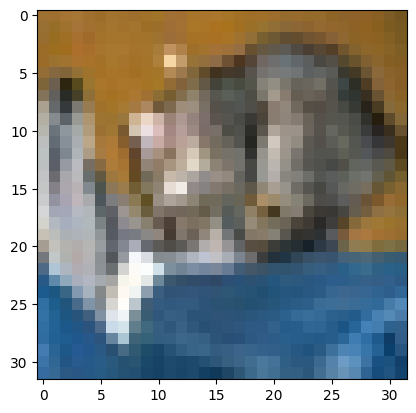

ship


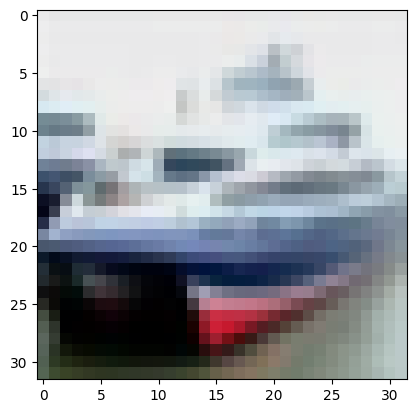

ship


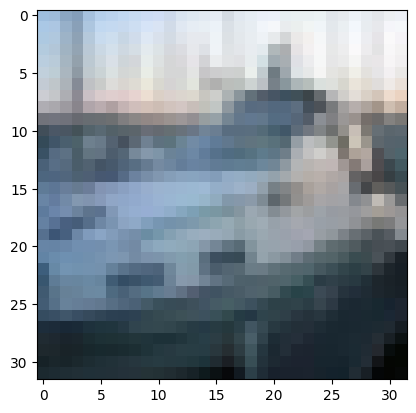

plane


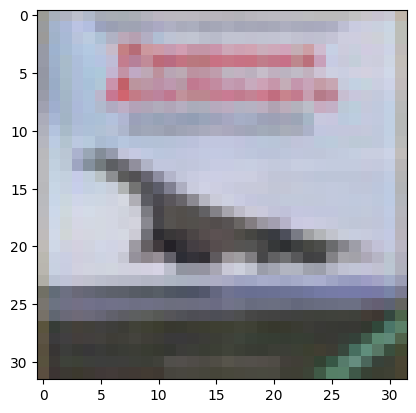

frog


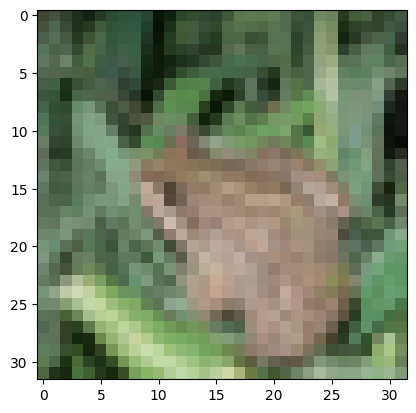

In [18]:
# Test Set
print("Test Data")
show5_regedit(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
class BaseClassifier(nn.Module):
    def __init__(self):
        super(BaseClassifier, self).__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Adjust the input size for CIFAR-10 images
        self.fc2 = nn.Linear(512, 256)  # Additional layer
        self.fc3 = nn.Linear(256, 128)  # Additional layer
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)  # Adjust the output size

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))  # Additional layer
        x = self.dropout(F.relu(self.fc3(x)))  # Additional layer
        x = self.dropout(F.relu(self.fc4(x)))

        x = F.log_softmax(self.fc5(x), dim=1)  # Adjust the output layer

        return x

# Create an instance of the BaseClassifier model
model = BaseClassifier()

# Print the model architecture
print(model)

BaseClassifier(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Create an instance of the SimpleClassifier model
model = SimpleClassifier()

# Print the model architecture
print(model)

SimpleClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
class DeeperClassifier(nn.Module):
    def __init__(self):
        super(DeeperClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Extend the fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 256)  # Extend the hidden units
        self.fc2 = nn.Linear(256, 128)  # Extend the hidden units
        self.fc3 = nn.Linear(128, 64)  # Extend the hidden units
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Keep 3 convolutional layers

        x = x.view(-1, 64 * 4 * 4)  # Adjust input size

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Create an instance of the DeeperClassifier model
model = DeeperClassifier()

# Print the model architecture
print(model)

DeeperClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
# Create an instance of the BaseClassifier model and move it to GPU
model = BaseClassifier()

# Check if GPU (CUDA) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model.to('cuda')
model.to(device)

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Load the saved model checkpoint (if exists)
model_filename = 'base_model_checkpoint.pth'
if os.path.exists(model_filename):
    model.load_state_dict(torch.load(model_filename))
    #model.to('cuda')  # Move the model back to GPU
    model.to(device)  # Move the model back to GPU if available

epochs = 30

best_val_loss = float('inf')  # Initialize with a very large value

history_00 = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for e in range(epochs):
    running_loss = 0
    correct_train = 0

    # Training loop
    for images, labels in trainloader:
        #images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct_train += equals.sum().item()

    accuracy_train = correct_train / len(trainloader.dataset)

    # Validation loop
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        #for images, labels in testloader:
        for images, labels in valloader:
            #images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        # val_loss = test_loss / len(testloader)
        # val_acc = accuracy / len(testloader)

        val_loss = test_loss / len(valloader)
        val_acc = accuracy / len(valloader)

        history_00['train_acc'].append(accuracy_train)
        history_00['train_loss'].append(running_loss/len(trainloader))
        history_00['val_acc'].append(val_acc)
        history_00['val_loss'].append(val_loss)

        # print("Epoch: {}/{}.. ".format(e+1, epochs),
        #       "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        #       "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(valloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))

    # Save the model checkpoint if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_filename)

Epoch: 1/30..  Training Loss: 2.043..  Test Loss: 1.934..  Test Accuracy: 0.298
Epoch: 2/30..  Training Loss: 1.969..  Test Loss: 1.891..  Test Accuracy: 0.305
Epoch: 3/30..  Training Loss: 1.948..  Test Loss: 1.851..  Test Accuracy: 0.314
Epoch: 4/30..  Training Loss: 1.932..  Test Loss: 1.823..  Test Accuracy: 0.313
Epoch: 5/30..  Training Loss: 1.925..  Test Loss: 1.810..  Test Accuracy: 0.341
Epoch: 6/30..  Training Loss: 1.922..  Test Loss: 1.843..  Test Accuracy: 0.318
Epoch: 7/30..  Training Loss: 1.924..  Test Loss: 1.808..  Test Accuracy: 0.340


In [ ]:
# Create an instance of the SimpleClassifier model and move it to GPU
model = SimpleClassifier()
model.to('cuda')

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Load the saved model checkpoint (if exists)
model_filename = 'model_checkpoint.pth'
if os.path.exists(model_filename):
  model.load_state_dict(torch.load(model_filename))
  model.to('cuda')  # Move the model back to GPU

epochs = 30
steps = 0

best_val_loss = float('inf')  # Initialize with a very large value

#train_losses, test_losses = [], []
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for e in range(epochs):
    running_loss = 0
    correct_train = 0

    # Training loop
    for images, labels in trainloader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct_train += equals.sum().item()

    accuracy_train = correct_train / len(trainloader.dataset)

    # Validation loop

    test_loss = 0
    accuracy = 0

        # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        #for images, labels in testloader:
        for images, labels in valloader:
                images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        # val_loss = test_loss / len(testloader)
        # val_acc = accuracy / len(testloader)
        val_loss = test_loss / len(valloader)
        val_acc = accuracy / len(valloader)

        history['train_acc'].append(accuracy_train)
        history['train_loss'].append(running_loss/len(trainloader))
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # print("Epoch: {}/{}.. ".format(e+1, epochs),
        #       "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        #       "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(valloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))

    # Save the model checkpoint if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_filename)

Epoch: 1/30..  Training Loss: 1.765..  Test Loss: 1.500..  Test Accuracy: 0.445
Epoch: 2/30..  Training Loss: 1.506..  Test Loss: 1.337..  Test Accuracy: 0.509
Epoch: 3/30..  Training Loss: 1.397..  Test Loss: 1.208..  Test Accuracy: 0.569
Epoch: 4/30..  Training Loss: 1.329..  Test Loss: 1.133..  Test Accuracy: 0.592
Epoch: 5/30..  Training Loss: 1.288..  Test Loss: 1.111..  Test Accuracy: 0.597
Epoch: 6/30..  Training Loss: 1.244..  Test Loss: 1.098..  Test Accuracy: 0.604
Epoch: 7/30..  Training Loss: 1.208..  Test Loss: 1.130..  Test Accuracy: 0.614
Epoch: 8/30..  Training Loss: 1.197..  Test Loss: 1.067..  Test Accuracy: 0.624
Epoch: 9/30..  Training Loss: 1.183..  Test Loss: 1.056..  Test Accuracy: 0.624
Epoch: 10/30..  Training Loss: 1.170..  Test Loss: 1.063..  Test Accuracy: 0.624
Epoch: 11/30..  Training Loss: 1.165..  Test Loss: 0.996..  Test Accuracy: 0.654
Epoch: 12/30..  Training Loss: 1.148..  Test Loss: 0.992..  Test Accuracy: 0.649
Epoch: 13/30..  Training Loss: 1.150.

In [ ]:
# Create an instance of the DeeperClassifier model and move it to GPU
model = DeeperClassifier()
model.to('cuda')

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Load the saved model checkpoint (if exists)
model_filename = 'deeperclassifier_model.pth'
if os.path.exists(model_filename):
  model.load_state_dict(torch.load(model_filename))
  model.to('cuda')  # Move the model back to GPU

epochs = 30
steps = 0

best_val_loss = float('inf')  # Initialize with a very large value

#train_losses, test_losses = [], []
history_02 = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for e in range(epochs):
    running_loss = 0
    correct_train = 0

    # Training loop
    for images, labels in trainloader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct_train += equals.sum().item()

    accuracy_train = correct_train / len(trainloader.dataset)

    # Validation loop

    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        #for images, labels in testloader:
        for images, labels in valloader:
                images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        # val_loss = test_loss / len(testloader)
        # val_acc = accuracy / len(testloader)
        val_loss = test_loss / len(valloader)
        val_acc = accuracy / len(valloader)

        history_02['train_acc'].append(accuracy_train)
        history_02['train_loss'].append(running_loss/len(trainloader))
        history_02['val_acc'].append(val_acc)
        history_02['val_loss'].append(val_loss)

        # print("Epoch: {}/{}.. ".format(e+1, epochs),
        #       "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        #       "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(valloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))

    # Save the model checkpoint if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_filename)

Epoch: 1/30..  Training Loss: 1.789..  Test Loss: 1.467..  Test Accuracy: 0.463
Epoch: 2/30..  Training Loss: 1.497..  Test Loss: 1.291..  Test Accuracy: 0.529
Epoch: 3/30..  Training Loss: 1.374..  Test Loss: 1.225..  Test Accuracy: 0.569
Epoch: 4/30..  Training Loss: 1.307..  Test Loss: 1.146..  Test Accuracy: 0.595
Epoch: 5/30..  Training Loss: 1.258..  Test Loss: 1.140..  Test Accuracy: 0.596
Epoch: 6/30..  Training Loss: 1.218..  Test Loss: 1.063..  Test Accuracy: 0.624
Epoch: 7/30..  Training Loss: 1.205..  Test Loss: 1.066..  Test Accuracy: 0.634
Epoch: 8/30..  Training Loss: 1.185..  Test Loss: 1.013..  Test Accuracy: 0.652
Epoch: 9/30..  Training Loss: 1.170..  Test Loss: 1.037..  Test Accuracy: 0.640
Epoch: 10/30..  Training Loss: 1.161..  Test Loss: 1.075..  Test Accuracy: 0.620
Epoch: 11/30..  Training Loss: 1.151..  Test Loss: 1.007..  Test Accuracy: 0.656
Epoch: 12/30..  Training Loss: 1.154..  Test Loss: 1.014..  Test Accuracy: 0.643
Epoch: 13/30..  Training Loss: 1.133.

In [ ]:
# Create an instance of the DeeperClassifier model and move it to GPU
model = DeeperClassifier()
model.to('cuda')

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Load the saved model checkpoint (if exists)
model_filename = 'deeperclassifier_model.pth'
if os.path.exists(model_filename):
  model.load_state_dict(torch.load(model_filename))
  model.to('cuda')  # Move the model back to GPU

epochs = 30
steps = 0

best_val_loss = float('inf')  # Initialize with a very large value

#train_losses, test_losses = [], []
#history_02 = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for e in range(epochs):
    running_loss = 0
    correct_train = 0

    # Training loop
    for images, labels in trainloader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct_train += equals.sum().item()

    accuracy_train = correct_train / len(trainloader.dataset)

    # Validation loop

    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation
    with torch.no_grad():
        model.eval()
        #for images, labels in testloader:
        for images, labels in valloader:
                images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        # val_loss = test_loss / len(testloader)
        # val_acc = accuracy / len(testloader)
        val_loss = test_loss / len(valloader)
        val_acc = accuracy / len(valloader)

        history_02['train_acc'].append(accuracy_train)
        history_02['train_loss'].append(running_loss/len(trainloader))
        history_02['val_acc'].append(val_acc)
        history_02['val_loss'].append(val_loss)

        # print("Epoch: {}/{}.. ".format(e+1, epochs),
        #       "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
        #       "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(valloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))

    # Save the model checkpoint if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_filename)

Epoch: 1/30..  Training Loss: 1.066..  Test Loss: 0.918..  Test Accuracy: 0.698
Epoch: 2/30..  Training Loss: 1.073..  Test Loss: 0.947..  Test Accuracy: 0.684
Epoch: 3/30..  Training Loss: 1.070..  Test Loss: 1.020..  Test Accuracy: 0.662
Epoch: 4/30..  Training Loss: 1.064..  Test Loss: 0.936..  Test Accuracy: 0.694
Epoch: 5/30..  Training Loss: 1.062..  Test Loss: 1.004..  Test Accuracy: 0.671
Epoch: 6/30..  Training Loss: 1.067..  Test Loss: 0.939..  Test Accuracy: 0.689
Epoch: 7/30..  Training Loss: 1.059..  Test Loss: 0.918..  Test Accuracy: 0.702
Epoch: 8/30..  Training Loss: 1.066..  Test Loss: 0.994..  Test Accuracy: 0.685
Epoch: 9/30..  Training Loss: 1.073..  Test Loss: 0.938..  Test Accuracy: 0.695
Epoch: 10/30..  Training Loss: 1.065..  Test Loss: 0.936..  Test Accuracy: 0.695
Epoch: 11/30..  Training Loss: 1.043..  Test Loss: 0.917..  Test Accuracy: 0.697
Epoch: 12/30..  Training Loss: 1.064..  Test Loss: 0.917..  Test Accuracy: 0.701
Epoch: 13/30..  Training Loss: 1.077.

Plot the training loss (and validation loss/accuracy, if recorded).

**Basic**

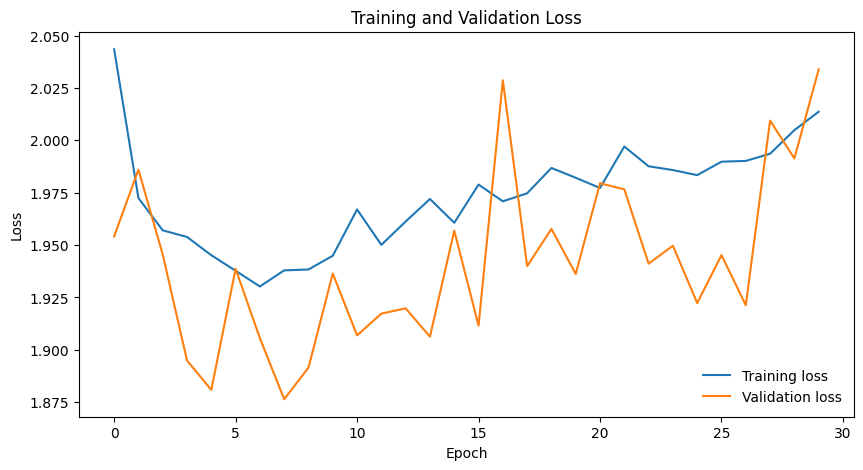

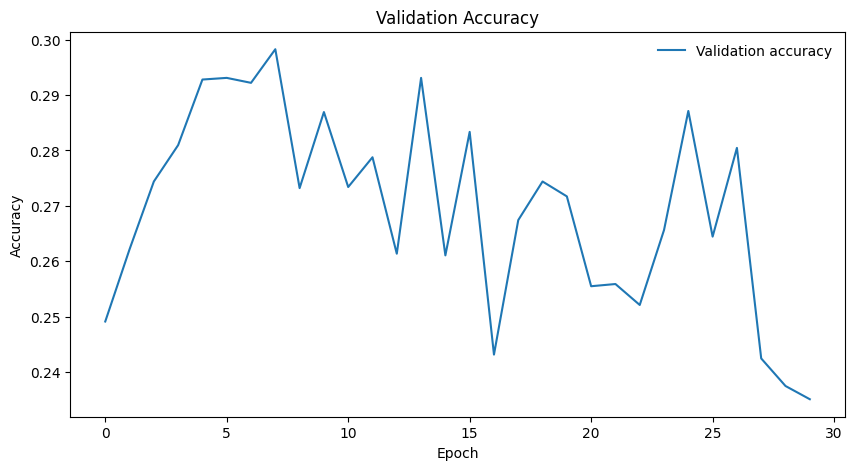

In [ ]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_00['train_loss'], label='Training loss')
val_loss_cpu = [loss.cpu() for loss in history_00['val_loss']]
plt.plot(val_loss_cpu, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_00['val_acc'], label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

**SimpleClassifier() Model**

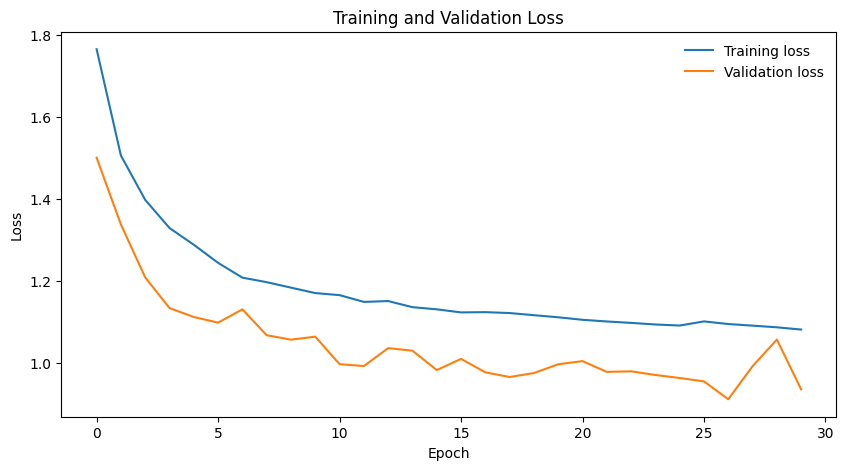

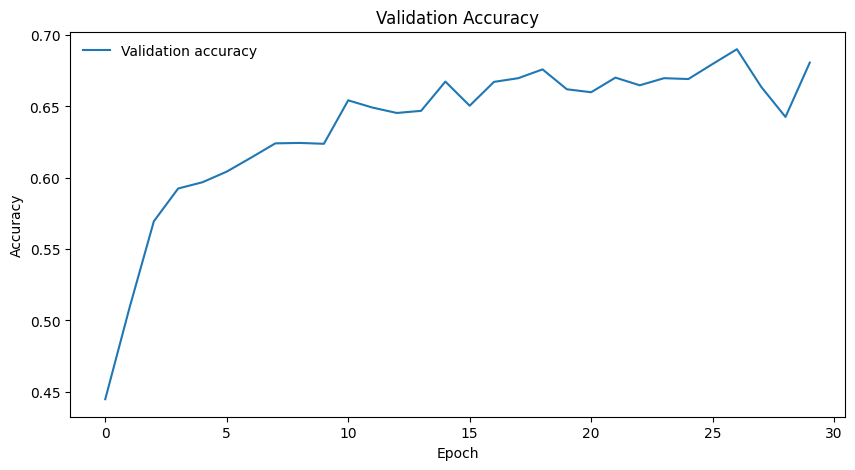

In [ ]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training loss')
val_loss_cpu = [loss.cpu() for loss in history['val_loss']]
plt.plot(val_loss_cpu, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

**DeeperClassifier() Model**

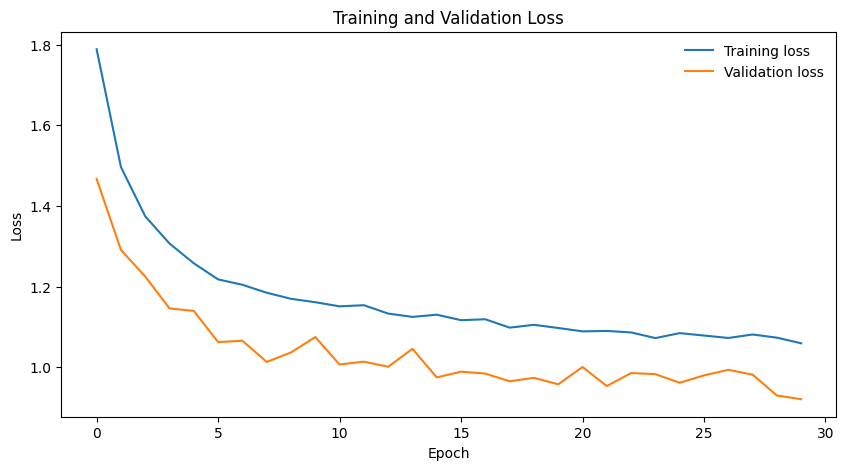

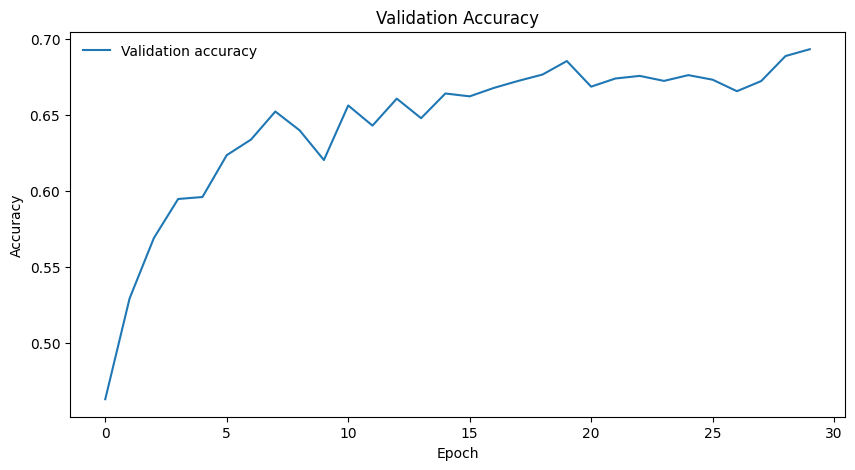

In [ ]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_02['train_loss'], label='Training loss')
val_loss_cpu = [loss.cpu() for loss in history_02['val_loss']]
plt.plot(val_loss_cpu, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_02['val_acc'], label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

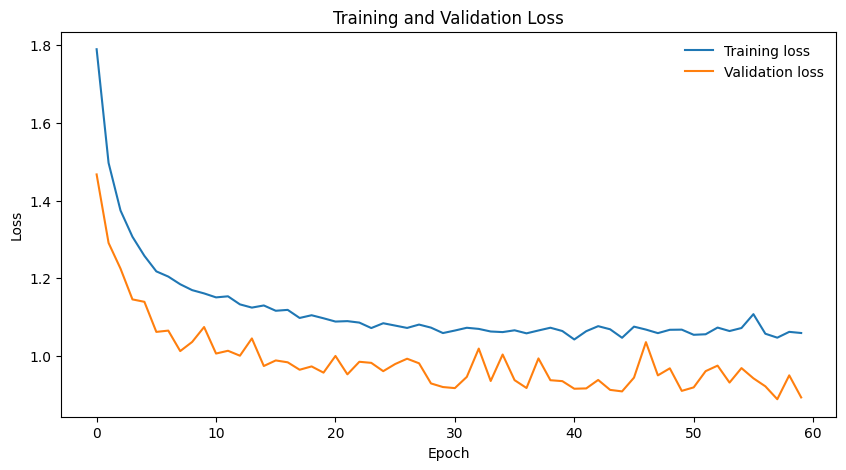

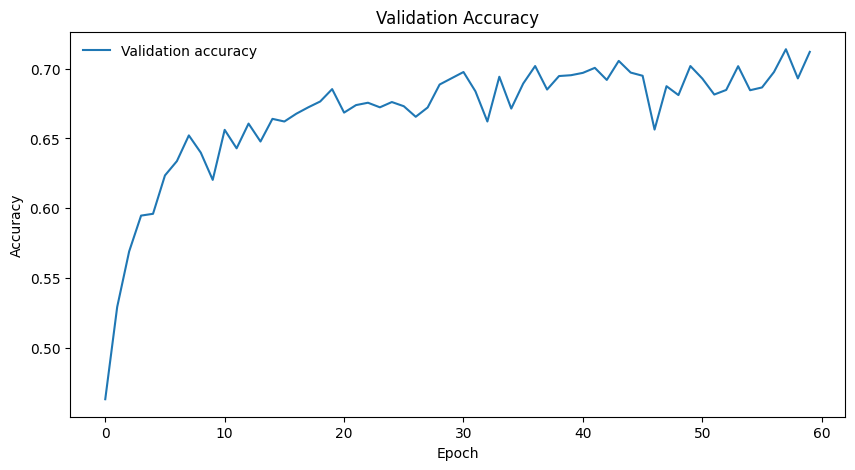

In [ ]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_02['train_loss'], label='Training loss')
val_loss_cpu = [loss.cpu() for loss in history_02['val_loss']]
plt.plot(val_loss_cpu, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_02['val_acc'], label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 70%, great work!
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

**BaseClassifier() Model**

In [ ]:
# Load the checkpoint model
model = BaseClassifier()
model_filename = 'base_model_checkpoint.pth'
model.load_state_dict(torch.load(model_filename))
model.to('cuda')
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct += equals.sum().item()
        total += labels.size(0)

accuracy = correct / total
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 29.82%


**SimpleClassifier() Model**

In [ ]:
# Load the checkpoint model
model = SimpleClassifier()
model_filename = 'model_checkpoint.pth'
model.load_state_dict(torch.load(model_filename))
model.to('cuda')
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct += equals.sum().item()
        total += labels.size(0)

accuracy = correct / total
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 69.07%


**DeeperClassifier() Model**

In [ ]:
# Load the checkpoint model
model = DeeperClassifier()
model_filename = 'deeperclassifier_model.pth'
model.load_state_dict(torch.load(model_filename))
model.to('cuda')
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        correct += equals.sum().item()
        total += labels.size(0)

accuracy = correct / total
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 71.31%


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
# Save Final Models

model = BaseClassifier()
model_filename = 'base_model_checkpoint.pth'
model.load_state_dict(torch.load(model_filename))
torch.save(model.state_dict(), 'trained_baseclassifier_model.pth')

model = SimpleClassifier()
model_filename = 'model_checkpoint.pth'
model.load_state_dict(torch.load(model_filename))
torch.save(model.state_dict(), 'trained_simpleclassifier_model.pth')

model = DeeperClassifier()
model_filename = 'deeperclassifier_model.pth'
model.load_state_dict(torch.load(model_filename))
torch.save(model.state_dict(), 'trained_deeperclassifier_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



I think our team should build our own object detection model.
Just experimenting with standard COV2D (Convolutional 2D) layers and fully connected layers, we were able to achieve 71% accuracy. Also, once we start to experiment with pretrained models, I believe we will have even better performance.

